In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from itertools import product

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

# отрисовка графиков
def plotly_df(df, col, title = ''):
    data = []
    
    trace = go.Scatter(
        x = df.index,
        y = df[col],
        mode = 'lines',
        name = col
    )
    data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [2]:
# Скачали данные
dataset = pd.read_excel('./Данные проект 2.xlsx', index_col='date')

In [3]:
def bus_metric(y_true, y_pred):
    dif = y_pred-y_true
    dif[dif<0] = np.abs(dif[dif<0]*2)
    return dif.sum()

def bus_MSE(y_true, y_pred):
    dif = y_pred-y_true
    dif[dif<0] = np.abs(dif[dif<0]*2)
    return (dif**2).sum()

In [4]:
plotly_df(dataset, 'manHours', title = "Man hours")

In [5]:
# Глянем, что там у нас
dataset.describe()

,manHours
count,220.000000
mean,514.590909
std,313.564404
min,1.000000
25%,309.000000
50%,378.500000
75%,751.250000
max,1571.000000


In [6]:
# Находим квантили
lower_bound = dataset['manHours'].quantile(0.05)
higher_bound = dataset['manHours'].quantile(0.95)

In [7]:
# Рубим квантили (можно попробовать их просто сдвинуть ближе к среднему)
new_df = dataset[(dataset['manHours'] > lower_bound.item()) & (dataset['manHours'] < higher_bound.item())]
plotly_df(new_df, 'manHours',title = "Man hours")

## Тройное экспоненциальное сглаживание a.k.a. Holt-Winters

Итак, успешно добрались до следующего варианта экспоненциального сглаживания, на сей раз тройного.

Идея этого метода заключается в добавлении еще одной, третьей, компоненты - сезонности. Соответственно, метод применим только в случае, если ряд этой сезонностью не обделён, что в нашем случае верно. Сезонная компонента в модели будет объяснять повторяющиеся колебания вокруг уровня и тренда, а характеризоваться она будет длиной сезона - периодом, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 7 (например, недельная сезонность), то получим 7 сезонных компонент, по штуке на каждый из дней недели.

Получаем новую систему:

$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$


$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$

$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$

$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$

Уровень теперь зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, тренд остаётся без изменений, а сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты. При этом компоненты сглаживаются через все доступные сезоны, например, если это компонента, отвечающая за понедельник, от и усредняться она будет только с другими понедельниками. Подробнее про работу усреднений и оценку начальных значений тренда и сезонных компонент можно почитать [здесь](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Теперь, имея сезонную компоненту, мы можем предсказывать уже не на один, и даже не на два, а на произвольные $m$ шагов вперёд, что не может не радовать. 

Ниже приведен код для построения модели тройного экспоненциального сглаживания, также известного по фамилиям её создателей - Чарльза Хольта и его студента Питера Винтерса. 
Дополнительно в модель включен метод Брутлага для построения доверительных интервалов:

$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$

$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$

$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}$,

где $T$ - длина сезона, $d$ - предсказанное отклонение, а остальные параметры берутся из тройного сглаживани. Подробнее о методе и о его применении к поиску аномалий во временных рядах можно прочесть [здесь](https://fedcsis.org/proceedings/2012/pliks/118.pdf)

In [8]:
class HoltWinters:
    
    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
            
            
        

## Кросс-валидация на временных рядах

Перед тем, как построить модель, поговорим, наконец, о не ручной оценке параметров для моделей. 

Ничего необычного здесь нет, по-прежнему сначала необходимо выбрать подходящуюю для данной задачи функцию потерь: [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation), [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error), [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) и др., которая будет следить за качеством подгонки модели под исходные данные. Затем будем оценивать на кросс-валидации значение функции потерь при данных параметрах модели, искать градиент, менять в соответствии с ним параметры и бодро опускаться в сторону глобального минимума ошибки. 

Небольшая загвоздка возникает только в кросс-валидации. Проблема состоит в том, что временной ряд имеет, как ни парадоксально, временную структуру, и случайно перемешивать в фолдах значения всего ряда без сохранения этой структуры нельзя, иначе в процессе потеряются все взаимосвязи наблюдений друг с другом. Поэтому придется использовать чуть более хитрый способ для оптимизации параметров, официального названия которому я так и не нашел, но на сайте [CrossValidated](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection), где можно найти ответы на всё, кроме главного вопроса Жизни, Вселенной и Всего Остального, предлагают название "cross-validation on a rolling basis", что не дословно можно перевести как кросс-валидация на скользящем окне.

Суть достаточно проста - начинаем обучать модель на небольшом отрезке временного ряда, от начала до некоторого $t$, делаем прогноз на $t+n$ шагов вперед и считаем ошибку. Далее расширяем обучающую выборку до $t+n$ значения и прогнозируем с $t+n$ до $t+2*n$, так продолжаем двигать тестовый отрезок ряда до тех пор, пока не упрёмся в последнее доступное наблюдение. В итоге получим столько фолдов, сколько $n$ уместится в промежуток между изначальным обучающим отрезком и всей длиной ряда.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Код для кросс-валидации на временном ряду. Значение длины сезона 24\*7 возникло не случайно - в исходном ряде отчетливо видна дневная сезонность, (отсюда 24), и недельная - по будням ниже, на выходных - выше, (отсюда 7), суммарно сезонных компонент получится 24\*7.

In [9]:
def timeseriesCVscore(x):
    # вектор ошибок
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 5*4, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

В модели Хольта-Винтерса, как и в остальных моделях экспоненциального сглаживания, есть ограничение на величину сглаживающих параметров - каждый из них может принимать значения от 0 до 1, поэтому для минимизации функции потерь нужно выбирать алгоритм, поддерживающий ограничения на параметры, в данном случае - Truncated Newton conjugate gradient.

In [10]:
%%time
data = new_df.manHours[:-20] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 1] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.08765473929168316 0.019333758474110674 0.6219942849640114
Wall time: 3.1 s


In [11]:
# Передаем оптимальные значения модели, 
data = new_df.manHours
model = HoltWinters(data[:-5], slen = 5*4, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 5, scaling_factor = 2.56)
model.triple_exponential_smoothing()

Код для отрисовки графика

In [12]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    print('metric %f' % bus_metric(data.values, model.result))
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

metric 19667.039135


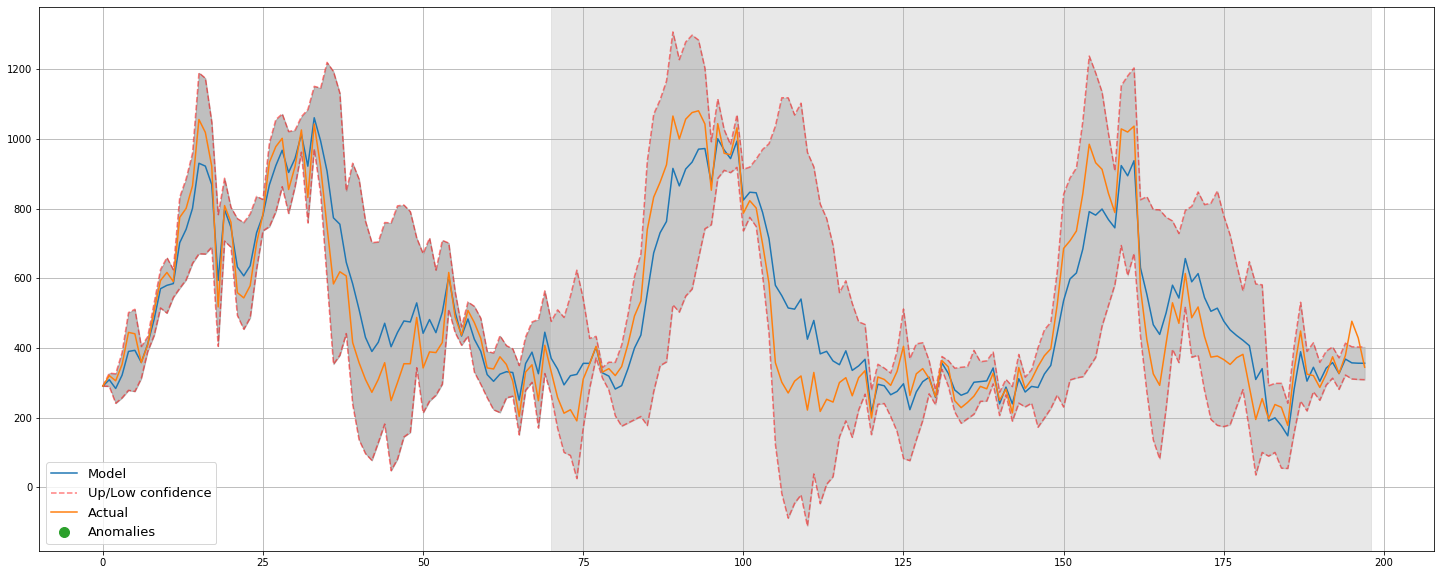

In [13]:
plotHoltWinters()

Судя по графику, модель неплохо описала исходный временной ряд, уловив недельную и дневную сезонность, и даже смогла поймать аномальные снижения, вышедшие за пределы доверительных интервалов. Если посмотреть на смоделированное отклонение, хорошо видно, что модель достаточно резко регирует на значительные изменения в структуре ряда, но при этом быстро возвращает дисперсию к обычным значениям, "забывая" прошлое. Такая особенность позволяет неплохо и без значительных затрат на подготовку-обучение модели настроить систему по детектированию аномалий даже в достаточно шумных рядах.

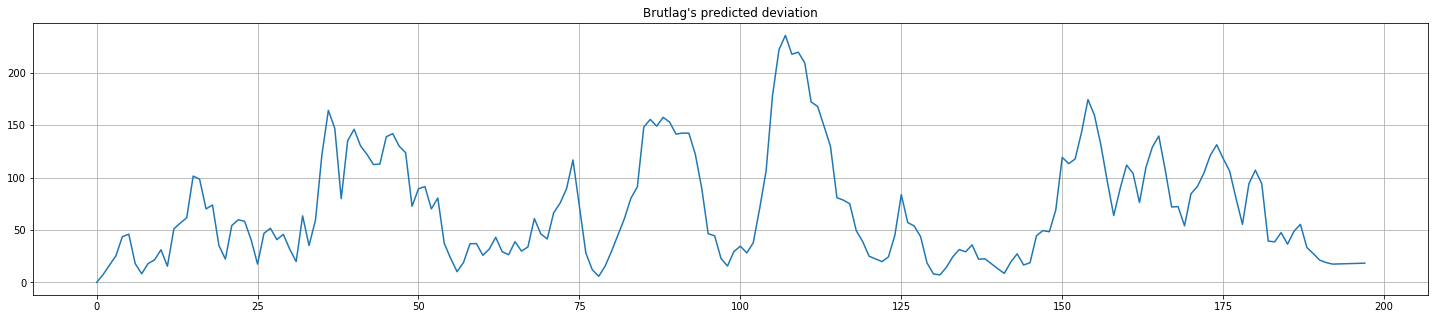

In [14]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

# Эконометрический подход

### Стационарность

Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как [**стационарность**](https://ru.wikipedia.org/wiki/Стационарность). 
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же [гомоскедастичность](https://ru.wikipedia.org/wiki/Гомоскедастичность)) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках, взятых из поста [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- Временной ряд справа не является стационарным, так как его матожидание со временем растёт

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- Здесь не повезло с дисперсией - разброс значений ряда существенно варьируется в зависимости от периода

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Наконец, на последнем графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределами учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

Чтобы бороться с нестационарностью, нужно узнать её в лицо, потому посмотрим, как её детектировать. Для этого обратимся к белому шуму и случайному блужданию, чтобы выяснить как попасть из одного в другое бесплатно и без смс.

График белого шума:

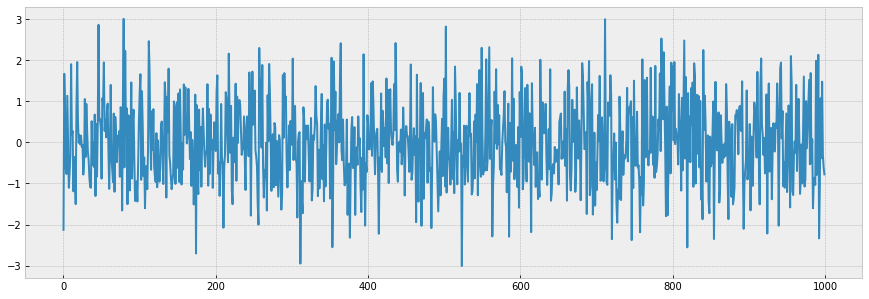

In [15]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

Итак, процесс, порожденный стандартным нормальным распределением, стационарен, колеблется вокруг нуля с отклонением в 1. Теперь на его основе сгенерируем новый процесс, в котором каждое последующее значение будет зависеть от предыдущего: $x_t = \rho x_{t-1} + e_t$ 

Код для отрисовки графиков

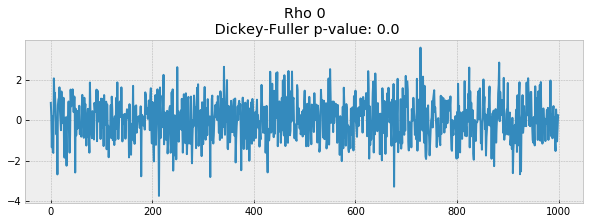

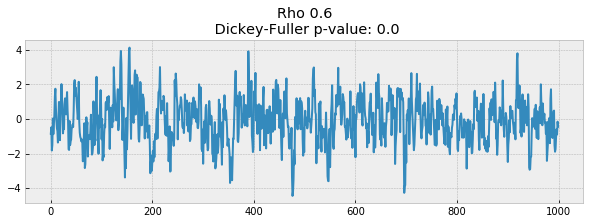

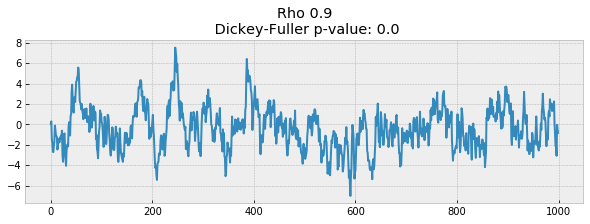

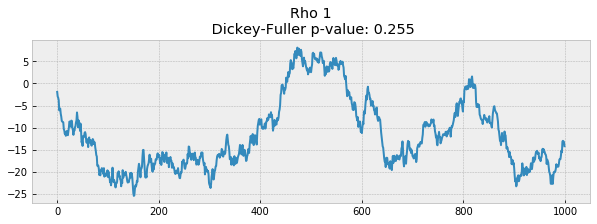

In [16]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

На первом графике получился точно такой же стационарный белый шум, который строился раньше. На втором значение $\rho$ увеличилось до 0.6, в результате чего на графике стали появляться более широкие циклы, но в целом стационарным он быть пока не перестал. Третий график всё сильнее отклоняется от нулевого среднего значения, но всё ещё колеблется вокруг него. Наконец, значение $\rho$ равное единице дало процесс случайного блуждания - ряд не стационарен.

Происходит это из-за того, что при достижении критической единицы, ряд $x_t = \rho x_{t-1} + e_t$ перестаёт возвращаться к своему среднему значению. Если вычесть из левой и правой части $x_{t-1}$, то получим $x_t - x_{t-1} = (\rho - 1) x_{t-1} + e_t$, где выражение слева - первые разности. Если $\rho=1$, то первые разности дадут стационарный белый шум $e_t$. Этот факт лёг в основу теста [Дики-Фуллера](https://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера) на стационарность ряда (наличие единичного корня). Если из нестационарного ряда первыми разностями удаётся получить стационарный, то он называется интегрированным первого порядка.
Нулевая гипотеза - ряд не стационарен, отвергалась на первых трех графиках, и принялась на последнем. Стоит сказать, что не всегда для получения стационарного ряда хватает первых разностей, так как процесс может быть интегрированным с более высоким порядком (иметь несколько единичных корней), для проверки таких случаев используют расширенный тест Дики-Фуллера, проверяющий сразу несколько лагов.

Бороться с нестационарностью можно множеством способов - разностями различного порядка, выделением тренда и сезонности, сглаживаниями и преобразованиями, например, Бокса-Кокса или логарифмированием.

## Избавляемся от нестационарности и строим SARIMA

In [17]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])


        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.056995


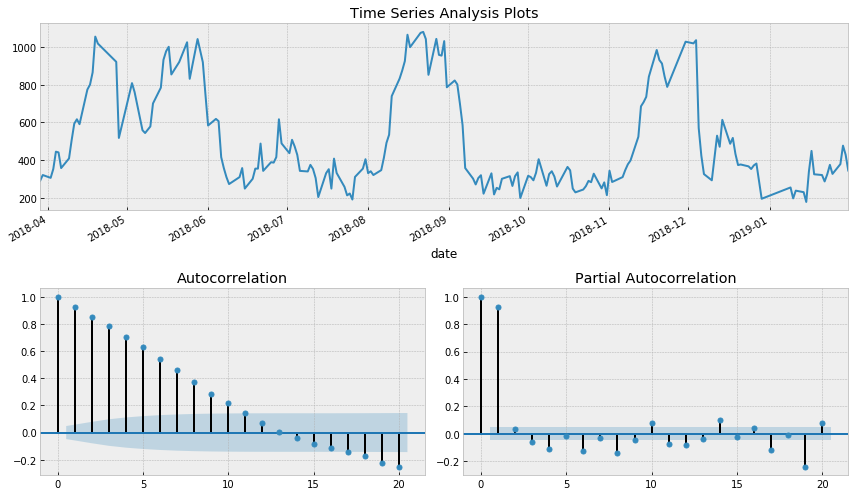

In [27]:
tsplot(new_df.manHours, lags=20)

Как и следовало ожидать, исходный ряд стационарным не является, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса

Критерий Дики-Фуллера: p=0.044640
Оптимальный параметр преобразования Бокса-Кокса: -0.469166


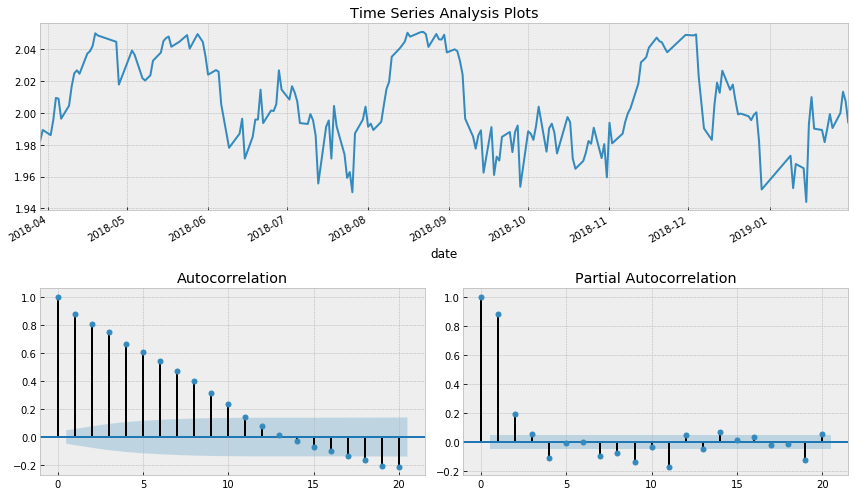

In [28]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


data = new_df.copy()
data['manHours_box'], lmbda = scs.boxcox(data.manHours) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.manHours_box, lags=20)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Уже лучше, однако критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности ряда. А автокорреляционная функция явно намекает на сезонность в получившемся ряде. Возьмём сезонные разности:

Критерий Дики-Фуллера: p=0.000000


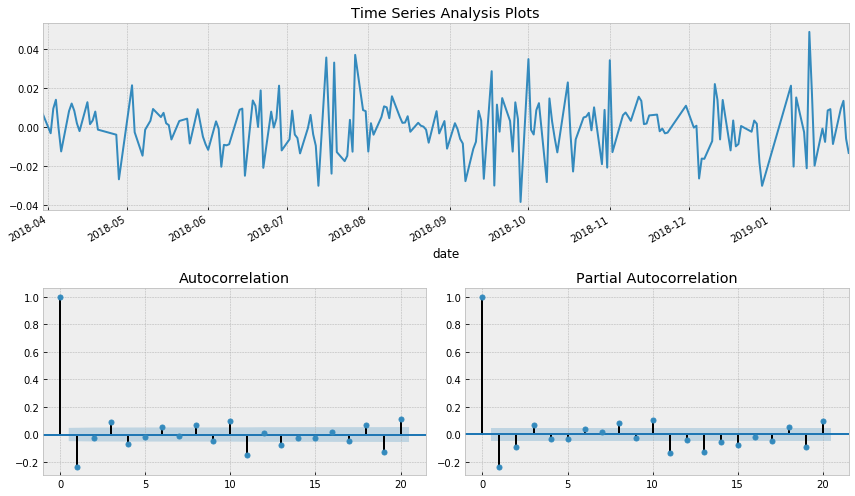

In [29]:
data['manHours_season'] = data.manHours_box - data.manHours_box.shift(1)
tsplot(data.manHours_season[1:].dropna(), lags=20)

D = 1
p = 3
q = 3


Критерий Дики-Фуллера теперь отвергает нулевую гипотезу о нестационарности, но автокорреляционная функция всё ещё выглядит нехорошо из-за большого числа значимых лагов. Так как на графике частной автокорреляционной функции значим лишь один лаг, стоит взять еще первые разности, чтобы привести, наконец, ряд к стационарному виду.

Критерий Дики-Фуллера: p=0.000000


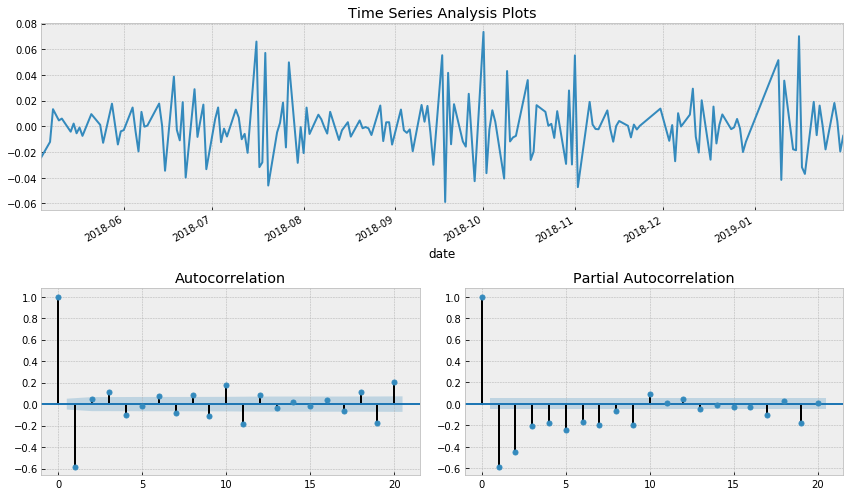

In [30]:
data['manHours_season_diff'] = data.manHours_season - data.manHours_season.shift(1)
tsplot(data.manHours_season_diff[20:].dropna(), lags=20)

Наконец, получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции прикинем параметры для SARIMA модели, на забыв, что предварительно уже сделали первые и сезонные разности.

Начальные приближения Q = 1, P = 4, q = 3, p = 4

In [31]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)



parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [35]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.manHours_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[3], D, param[3], 30)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

parameters         aic
71  (3, 2, 1, 0) -847.235609
74  (3, 2, 4, 0) -847.235609
73  (3, 2, 3, 0) -847.235609
72  (3, 2, 2, 0) -847.235609
70  (3, 2, 0, 0) -847.235609
Wall time: 2min 4s


In [36]:
data.shape


(198, 4)

Лучшие параметры загоняем в модель:

In [37]:
%%time
best_model=sm.tsa.statespace.SARIMAX(data.manHours_box, order=(3, d, 3), 
                                        seasonal_order=(3, D, 1, 30)).fit(disp=-1)

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

Wall time: 58.9 s


In [38]:
print(best_model.summary())

Statespace Model Results                                 
Dep. Variable:                       manHours_box   No. Observations:                  198
Model:             SARIMAX(3, 1, 3)x(3, 1, 1, 30)   Log Likelihood                 466.686
Date:                            Sat, 22 Feb 2020   AIC                           -911.372
Time:                                    17:44:27   BIC                           -877.074
Sample:                                         0   HQIC                          -897.451
                                            - 198                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0663      8.931     -0.007      0.994     -17.570      17.437
ar.L2         -0.0123      4.658     -0.003      0.998      -9.141  

Проверим остатки модели:

Критерий Дики-Фуллера: p=0.000000


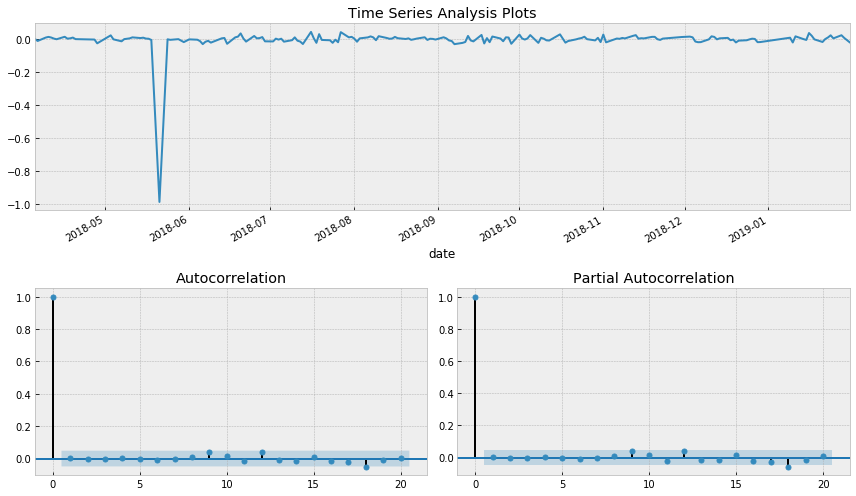

In [39]:
tsplot(best_model.resid[5:], lags=20)

Что ж, остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in less

nan


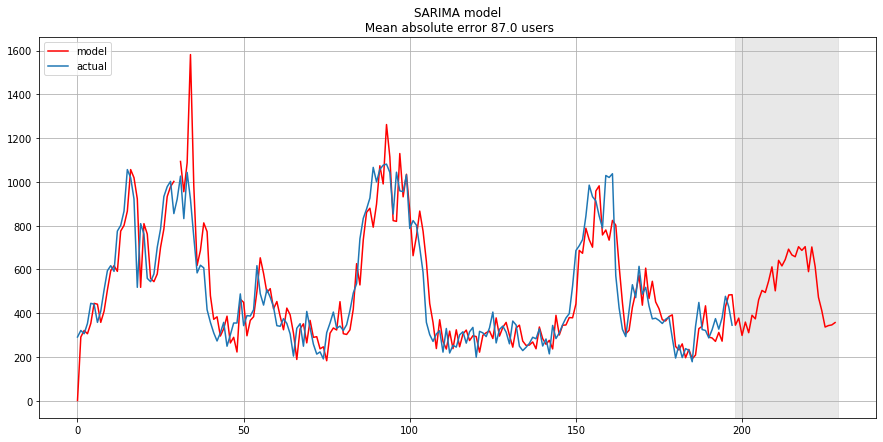

In [48]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+30), lmbda)
forecast = data.arima_model.append(forecast).values
actual = data.manHours.values
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
print(bus_metric(actual, forecast[:198]))
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().manHours, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

# Линейные и не очень модели на временных рядах

Снова небольшое лирическое отступление. Часто на работе приходится строить модели, руководствуясь одним основополагающим принципом – [*быстро, качественно, недорого*](http://lurkmore.to/Быстро,_качественно,_недорого). Поэтому часть моделей могут банально не подойти для "продакшн-решений", так как либо требуют слишком больших затрат по подготовке данных (например, SARIMA), либо сложно настраиваются (хороший пример – SARIMA), либо требуют частого переобучения на новых данных (опять SARIMA), поэтому зачастую гораздо проще бывает выделить несколько признаков из имеющегося временного ряда и построить по ним обычную линейную регрессию или навесить решаюший лес. Дешево и сердито.

Возможно, этот подход не является значительно подкрепленным теорией, нарушает различные предпосылки, например, условия Гаусса-Маркова, особенно пункт про некоррелированность ошибок, однако на практике нередко выручает и достаточно активно используется в соревнованиях по машинному обучению.

# Извлечение признаков (Feature exctraction)

Помимо стандартных признаков вроде лагов целевой переменной, много информации содержат в себе дата и время. Про извлечение признаков из них уже здорово описано в одной из [предыдущих статей](https://habrahabr.ru/company/ods/blog/325422/#vremennye-ryady-veb-i-prochee) курса.

Добавлю только про еще один вариант кодирования категориальных признаков – кодирование средним. Если не хочется раздувать датасет множеством дамми-переменных, которые могут привести к потере информации о расстоянии, а в вещественном виде возникают противоречивые результаты а-ля "0 часов < 23 часа", то можно закодировать переменную чуть более интерпретируемыми значениями. Естественный вариант – закодировать средним значением целевой переменной. В нашем случае каждый день недели или час дня можно закодировать сооветствующим средним числом игроков, находившихся в этот день недели или час онлайн. При этом важно следить за тем, чтобы расчет среднего значения производился только в рамках тестового датасета (или в рамках текущего наблюдаемого фолда при кросс-валидации), иначе можно ненароком привнести в модель информацию о будущем.

In [2]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Создадим новый датафрейм и добавим в него час, день недели и выходной в качестве категориальных переменных. Для этого переводим имеющийся в датафрейме индекс в формат `datetime`, и извлекаем из него `hour` и `weekday`.

In [3]:
data = pd.DataFrame(new_df.copy())

#data.index = data.index.to_datetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

NameError: name 'pd' is not defined

Посмотрим на средние по дням недели

In [1]:
code_mean(data, 'weekday', "manHours")

NameError: name 'code_mean' is not defined

Помимо перечисленных преобразований для увеличения числа признаков используют и множество других метрик, например, максимальное/минимальное значение, наблюдавшееся в скользящем по ряду окне, медианы, число пиков, взвешенные дисперсии и многое другое. Автоматически этим занимается уже упоминавшаяся в курсе [библиотека tsfresh](https://github.com/blue-yonder/tsfresh).

Для удобства все преобразования можно записать в одну функцию, которая сразу же будет возвращать разбитые на трейн и тест датасеты и целевые переменные.

In [21]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # # Добавили значение дня недели
    # data['date'] = data.index
    # data['weekday'] = data['date'].dt.weekday

    # # Закодируем это дело в OneHot и присоединим
    # one = OneHotEncoder(sparse=False)

    # tmp = pd.DataFrame(one.fit_transform(data.drop(['date', 'y'], axis=1)))
    # tmp.index = data.index
    # data = pd.concat([data.drop(['weekday', 'date'], axis=1), tmp],axis=1)
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    #data.index = data.index.to_datetime()
    data["weekday"] = data.index.weekday
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))

    # выкидываем закодированные средними признаки 
    data.drop(["weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

Обучим на получившихся данных простую линейную регрессию. При этом лаги будем брать начиная с двенадцатого, таким образом модель будет способна строить предсказания на 12 часов вперёд, имея фактические наблюдения за предыдущие пол дня

2620.2095910703238


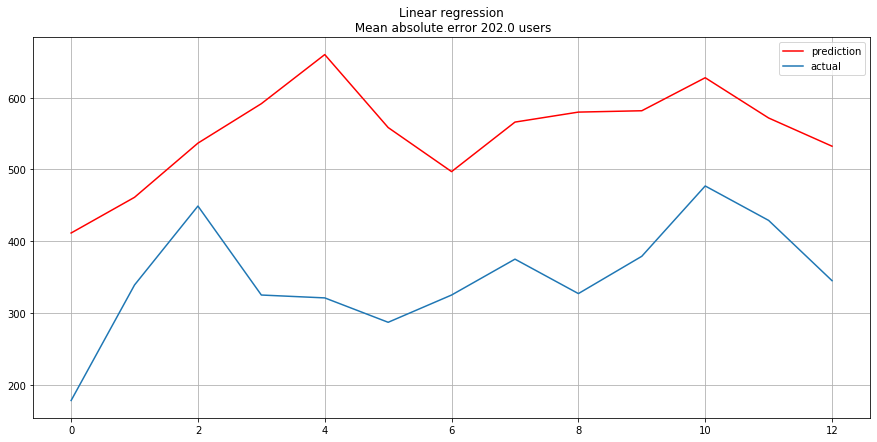

In [23]:
X_train, X_test, y_train, y_test = prepareData(new_df.manHours, test_size=0.3, lag_start=12, lag_end=48)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
print(bus_metric(y_test, prediction))
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [114]:
X_test

,0,1,2,3,4,5,lag_12,lag_13,lag_14,lag_15,...,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,weekday_average
138,0.0,1.0,0.0,0.0,0.0,0.0,374.0,433.0,518.0,487.0,...,347.0,310.0,284.0,344.0,214.0,282.0,250.0,328.0,283.0,499.120000
139,0.0,0.0,1.0,0.0,0.0,0.0,377.0,374.0,433.0,518.0,...,378.0,347.0,310.0,284.0,344.0,214.0,282.0,250.0,328.0,508.653846
140,0.0,0.0,0.0,1.0,0.0,0.0,367.0,377.0,374.0,433.0,...,398.0,378.0,347.0,310.0,284.0,344.0,214.0,282.0,250.0,555.862069
141,0.0,0.0,0.0,0.0,1.0,0.0,353.0,367.0,377.0,374.0,...,524.0,398.0,378.0,347.0,310.0,284.0,344.0,214.0,282.0,506.666667
142,1.0,0.0,0.0,0.0,0.0,0.0,372.0,353.0,367.0,377.0,...,686.0,524.0,398.0,378.0,347.0,310.0,284.0,344.0,214.0,527.076923
143,0.0,1.0,0.0,0.0,0.0,0.0,382.0,372.0,353.0,367.0,...,708.0,686.0,524.0,398.0,378.0,347.0,310.0,284.0,344.0,499.120000
144,0.0,0.0,1.0,0.0,0.0,0.0,289.0,382.0,372.0,353.0,...,736.0,708.0,686.0,524.0,398.0,378.0,347.0,310.0,284.0,508.653846
145,0.0,0.0,0.0,1.0,0.0,0.0,195.0,289.0,382.0,372.0,...,843.0,736.0,708.0,686.0,524.0,398.0,378.0,347.0,310.0,555.862069
146,0.0,0.0,0.0,0.0,1.0,0.0,255.0,195.0,289.0,382.0,...,985.0,843.0,736.0,708.0,686.0,524.0,398.0,378.0,347.0,506.666667
147,1.0,0.0,0.0,0.0,0.0,0.0,197.0,255.0,195.0,289.0,...,932.0,985.0,843.0,736.0,708.0,686.0,524.0,398.0,378.0,527.076923


Получилось достаточно неплохо, даже отбора признаков модель ошибается, в среднем, на 3K пользователей в час, и это учитывая огромный выброс в середине тестового ряда.

Также можно провести оценку модели на кросс-валидации, тому же принципу, что был использован ранее. Для этого воспользуемся функцией (с небольшими модификациями), предложенной в посте [Pythonic Cross Validation on Time Series](http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/)

In [24]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))
    
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print()
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))
        
        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]
        
        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    
    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [25]:
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (139, 37)
Size of each fold: 27

Splitting the first 2 chunks at 1/2
Size of train + test: (54, 37)

Splitting the first 3 chunks at 2/3
Size of train + test: (81, 37)

Splitting the first 4 chunks at 3/4
Size of train + test: (108, 37)

Splitting the first 5 chunks at 4/5
Size of train + test: (135, 37)


313.650508900546

На 5 фолдах получили среднюю абсолютную ошибку в 4.6 K пользователей, достаточно близко к оценке качества, полученной на тестовом датасете.

Почему бы теперь не попробовать XGBoost
<img src="https://habrastorage.org/files/754/a9a/26e/754a9a26e59648de9fe2487241a27c43.jpg"/>

In [120]:
!pip install xgboost

C:\Users\User\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning:

unclosed file <_io.BufferedWriter name=6>

C:\Users\User\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning:

unclosed file <_io.BufferedReader name=7>

C:\Users\User\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning:

unclosed file <_io.BufferedReader name=8>



In [26]:
sys.path.append('/Users/dmitrys/xgboost/python-package/')

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):
    
    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(dataset.manHours, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    
    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000
    
    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)
    
    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())
    
    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])
    
    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]
    
    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)
    
    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

In [27]:
XGB_forecast(dataset, test_size=0.2, lag_start=12, lag_end=48)

[21:30:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:30:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:30:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:30:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:30:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:30:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:30:38] WARNI

ValueError: could not convert string to float: '-nan(ind)'

Те же 3 K пользователей в средней абсолютной ошибке, и неплохо пойманные аномалии на тестовом датасете. Конечно, чтобы уменьшить ошибку, еще можно повозиться с параметрами, настроить при необходимости регуляризацию, отобрать признаки, понять, на сколько лагов нужно уходить вглубь истории и т.д. 